100%|██████████| 9912422/9912422 [00:00<00:00, 229375641.33it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26553199.00it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67874724.18it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7875373.61it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Epoch #1


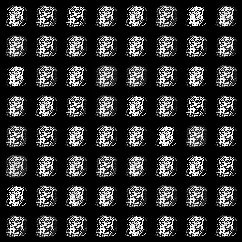



Epoch #2


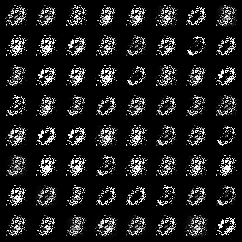



Epoch #3


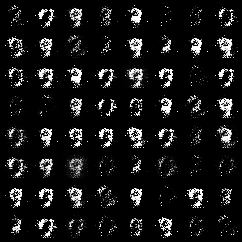



Epoch #4


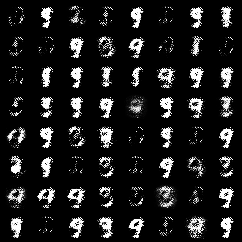



Epoch #5


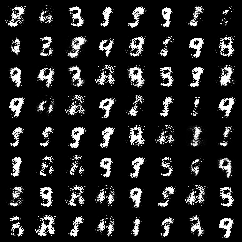



Epoch #6


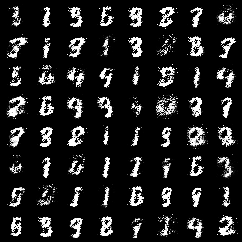



Epoch #7


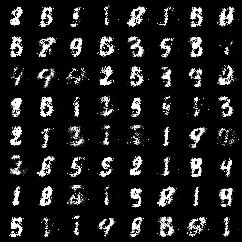



Epoch #8


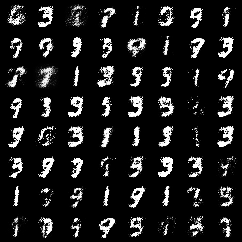



Epoch #9


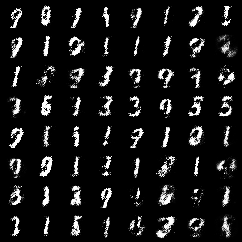



Epoch #10


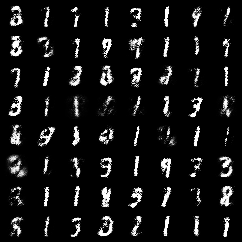



Epoch #11


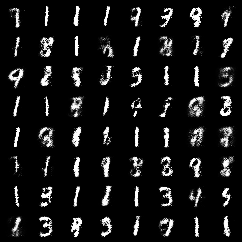



Epoch #12


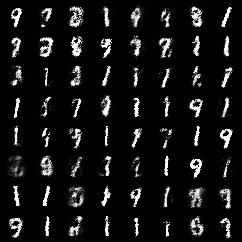



Epoch #13


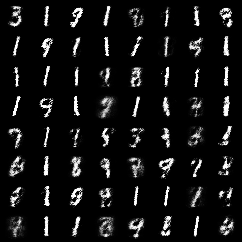



Epoch #14


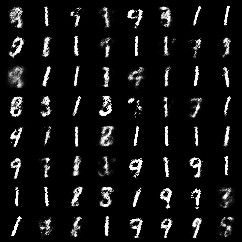



Epoch #15


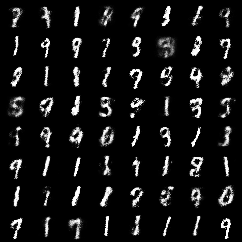



Epoch #16


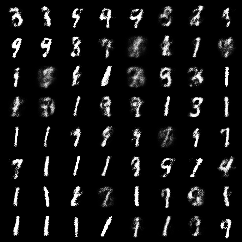



Epoch #17


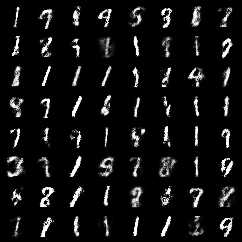



Epoch #18


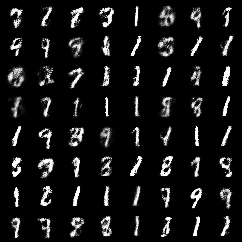



Epoch #19


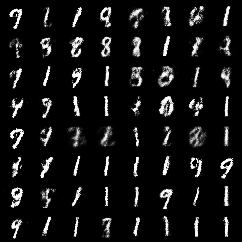



Epoch #20


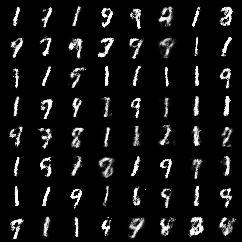



Epoch #21


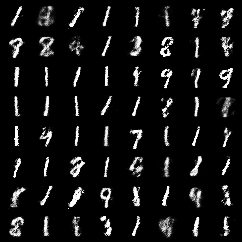



Epoch #22


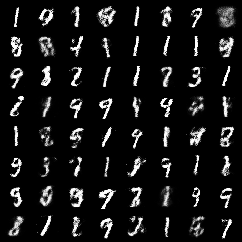



Epoch #23


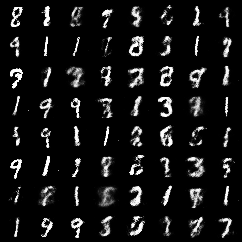



Epoch #24


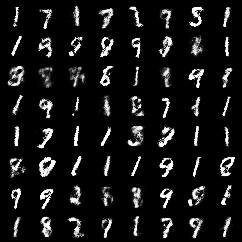



Epoch #25


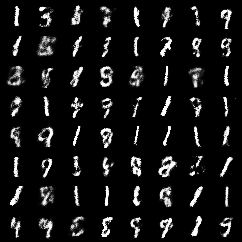



Epoch #26


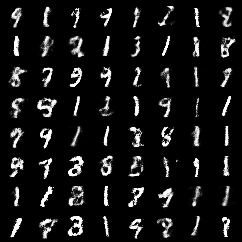



Epoch #27


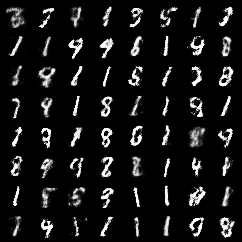



Epoch #28


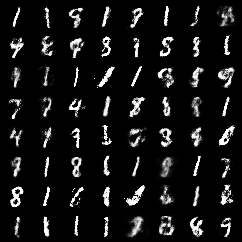



Epoch #29


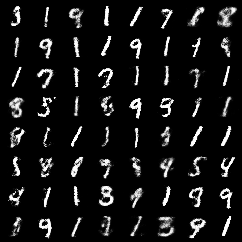



Epoch #30


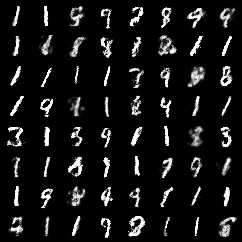



Epoch #31


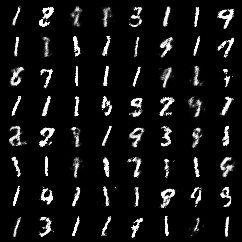



Epoch #32


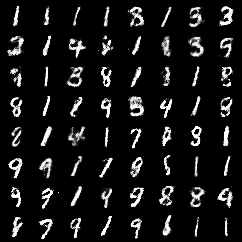



Epoch #33


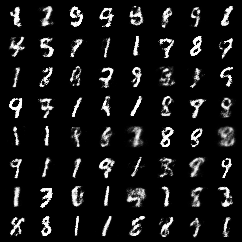



Epoch #34


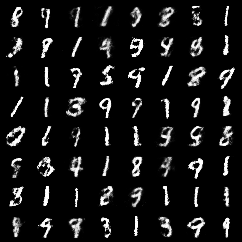



Epoch #35


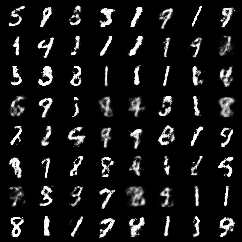



Epoch #36


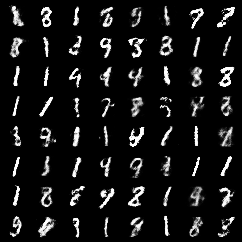



Epoch #37


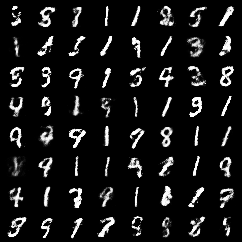



Epoch #38


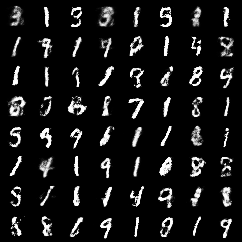



Epoch #39


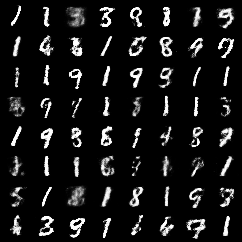



Epoch #40


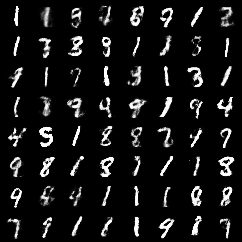



Epoch #41


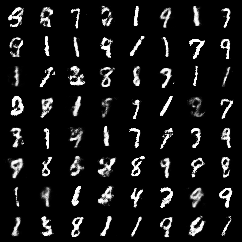



Epoch #42


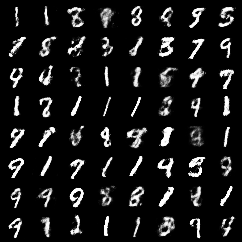



Epoch #43


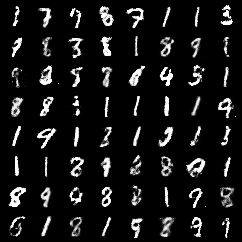



Epoch #44


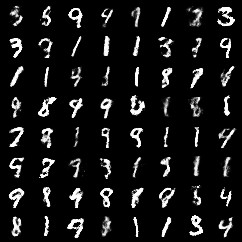



Epoch #45


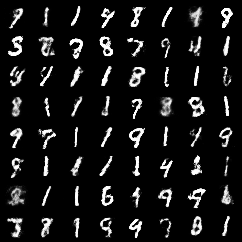



Epoch #46


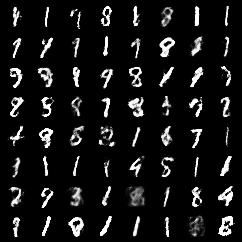



Epoch #47


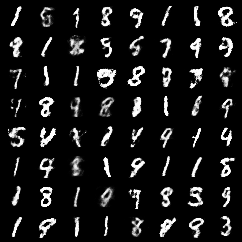



Epoch #48


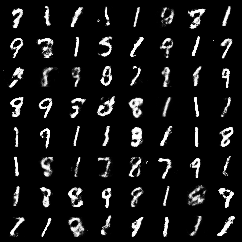



Epoch #49


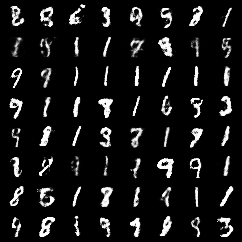



Epoch #50


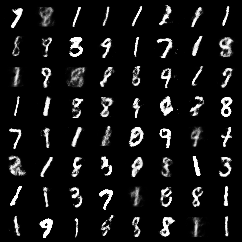

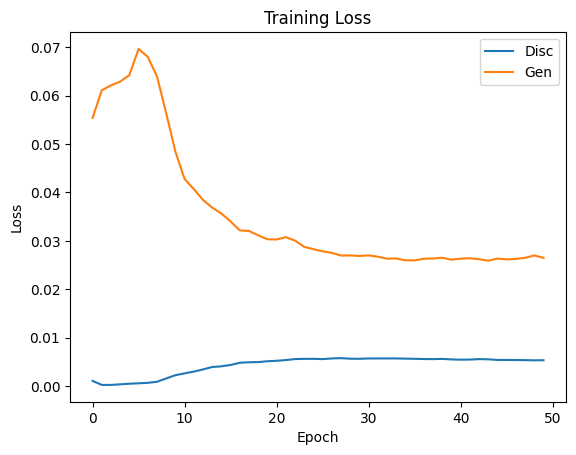

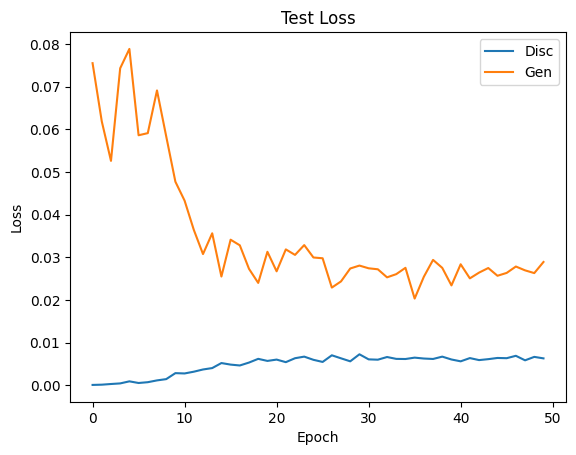

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.gen = nn.Sequential(
          nn.Linear(latent_size, 400),
          nn.ReLU(True),
          nn.Linear(400, 784),
          nn.Sigmoid())

    def forward(self, z):
      return self.gen(z).view(-1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.disc = nn.Sequential(
          nn.Linear(784, 400),
          nn.ReLU(True),
          nn.Linear(400, 1),
          nn.Sigmoid()
      )

    def forward(self, x):
      x = x.view(-1, 784)
      return self.disc(x)

def train(generator, generator_optimizer, discriminator, discriminator_optimizer):
    total_gen_loss = 0
    total_disc_loss = 0

    criterion = nn.BCELoss()

    generator.train()
    discriminator.train()

    for _, (real_images, _) in enumerate(train_loader):
      real_images = real_images.to(device)
      batch_size = real_images.size(0)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)
      z = torch.randn(batch_size, latent_size).to(device)

      generator_optimizer.zero_grad()
      fake_images = generator(z)
      outputs = discriminator(fake_images)
      gen_loss = criterion(outputs, real_labels)
      gen_loss.backward()
      generator_optimizer.step()

      discriminator_optimizer.zero_grad()
      outputs = discriminator(real_images)
      real_loss = criterion(outputs, real_labels)
      outputs = discriminator(fake_images.detach())
      fake_loss = criterion(outputs, fake_labels)
      disc_loss = real_loss + fake_loss
      disc_loss.backward()
      discriminator_optimizer.step()

      total_gen_loss += gen_loss.item()
      total_disc_loss += disc_loss.item()

    avg_generator_loss = total_gen_loss / len(train_loader.dataset)
    avg_discriminator_loss = total_disc_loss / len(train_loader.dataset)
    return avg_generator_loss, avg_discriminator_loss

def test(generator, discriminator):
    total_gen_loss = 0
    total_disc_loss = 0

    criterion = nn.BCELoss()

    generator.eval()
    discriminator.eval()

    with torch.no_grad():
      for _, (real_images, _) in enumerate(test_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, latent_size).to(device)

        fake_images = generator(z)

        outputs = discriminator(fake_images)
        gen_loss = criterion(outputs, real_labels)

        outputs = discriminator(fake_images)
        fake_loss = criterion(outputs, fake_labels)

        outputs = discriminator(real_images)
        real_loss = criterion(outputs, real_labels)

        disc_loss = real_loss + fake_loss

        total_gen_loss += gen_loss.item()
        total_disc_loss += disc_loss.item()

    avg_generator_loss = total_gen_loss / len(test_loader.dataset)
    avg_discriminator_loss = total_disc_loss / len(test_loader.dataset)

    return avg_generator_loss, avg_discriminator_loss


epochs = 50

discriminator_avg_train_losses = []
discriminator_avg_test_losses = []
generator_avg_train_losses = []
generator_avg_test_losses = []

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    generator_avg_train_loss, discriminator_avg_train_loss = train(generator, generator_optimizer, discriminator, discriminator_optimizer)
    generator_avg_test_loss, discriminator_avg_test_loss = test(generator, discriminator)

    discriminator_avg_train_losses.append(discriminator_avg_train_loss)
    generator_avg_train_losses.append(generator_avg_train_loss)
    discriminator_avg_test_losses.append(discriminator_avg_test_loss)
    generator_avg_test_losses.append(generator_avg_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = generator(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

plt.plot(discriminator_avg_train_losses)
plt.plot(generator_avg_train_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()

plt.plot(discriminator_avg_test_losses)
plt.plot(generator_avg_test_losses)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()